# Imports

In [ ]:
!pip install sklearn-som
from sklearn_som.som import SOM as som_lib

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

# datasets
from sklearn.datasets import fetch_covtype
from sklearn.datasets import load_iris

# Dataset

In [2]:
iris = load_iris()
x = iris.data[:,2:]
y = iris.target

# x = np.random.random((1000, 2))
# y = np.ones(1000)

In [3]:
x = MinMaxScaler().fit_transform(x)

# Using SOM from sklearn_som

In [ ]:
%%time
somlib = som_lib(m=3, n=3, dim=xtrain.shape[1])
somlib.fit(xtrain)
predictions = somlib.predict(xtrain)
print(len(predictions))
newx = somlib._locations[predictions]

112
CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 20.8 ms


# SOM

In [10]:
t = np.linspace(-1, 1, (3*2)).reshape(3, 2)
t2 = np.linspace(-1, 1, (3*2)).reshape(3, 2)
print(t)
print(t2)

[[-1.  -0.6]
 [-0.2  0.2]
 [ 0.6  1. ]]
[[-1.  -0.6]
 [-0.2  0.2]
 [ 0.6  1. ]]


In [34]:
class SOM():
    def __init__(self, m=3, n=3, dim=2, sigma=0.05, epochs=20, learning_rate=0.85, usePCA=False):
        """
        Parameters
        ----------
        m : int, default=3
            The shape along dimension 0 (vertical) of the SOM.
        n : int, default=3
            The shape along dimesnion 1 (horizontal) of the SOM.
        """
        # Initialize descriptive features of SOM
        self.usePCA = usePCA
        self.m = m
        self.n = n
        self.epochs = epochs
        self.dim = dim
        self.learning_rate = learning_rate
        self.learning_rate0 = learning_rate
        self.radius = sigma
        self.radius0 = self.radius 

        self.predictions = None
  
        self.map = np.random.random((m*n, dim))
        self.map_locations = np.argwhere(np.ones(shape=(m, n)))
        
 

    def __initWithPCA(self, x=None):
      principalaxes = PCA(2).fit(x).components_
      a1 = np.linspace(-1, 1, (self.m*self.dim)).reshape(self.m, self.dim)
      a2 = np.linspace(-1, 1, (self.n*self.dim)).reshape(self.n, self.dim)
      #a1 = np.random.random((self.m, self.dim))
      #a2 = np.random.random((self.n, self.dim))
      self.map = np.array([a1[m]*principalaxes[0] + a2[n]*principalaxes[1] for m in range(self.m) for n in range(self.n)])

    def __euclidian(self, v1, v2):
      return np.linalg.norm(v1-v2, axis=1)


    def __findbmu(self, v):
      distances = self.__euclidian(v, self.map)
      bmu = np.argmin(distances)
      return bmu

    # neighborhood function
    def __neighborhoodFunction(self, bmu):
      bmu_location = self.map_locations[bmu]
      bmu_location_stack = np.stack([bmu_location]*(self.m*self.n), axis=0)
      distances = self.__euclidian(bmu_location_stack, self.map_locations) # distances from neighborhood indices
      h = self.learning_rate * np.exp((- distances / (2 * self.radius**2))) # list of hci for each node
      hstack = np.stack([h]*(self.dim), axis=1)
      return hstack
    
    def __update_weights(self, bmu, x, hstack):
      xstack = np.stack([x]*(self.m*self.n), axis=0)
      self.map = self.map + hstack*(xstack - self.map) 

    def fit(self, x=None):
      if self.usePCA:
        self.__initWithPCA(x)
      self.map_history = [self.map]
      
      for epoch in tqdm(range(1, self.epochs+1)):

        self.predictions = [self.__findbmu(v) for v in x] # bmu's indexes
        for i, bmu in enumerate(self.predictions):
          self.__update_weights(bmu, x[i], self.__neighborhoodFunction(bmu))

        self.learning_rate = self.learning_rate0 / epoch
        self.radius = self.radius0 * np.exp(-epoch/self.epochs)
        self.map_history.append(self.map)
      return self

    def transform(self, x=None):
      predictions = [self.__findbmu(v) for v in x] # bmu's indexes
      return self.map_locations[predictions]

    def fit_transform(self, x):
      self.fit(x)
      return self.transform(x)


# Testing

In [29]:
%%time
som = SOM(3, 3, x.shape[1], epochs=20, usePCA=True, sigma=1)
xfited = som.fit_transform(x)

100%|██████████| 20/20 [00:00<00:00, 89.12it/s]

CPU times: user 235 ms, sys: 1.87 ms, total: 237 ms
Wall time: 237 ms


# Visualization

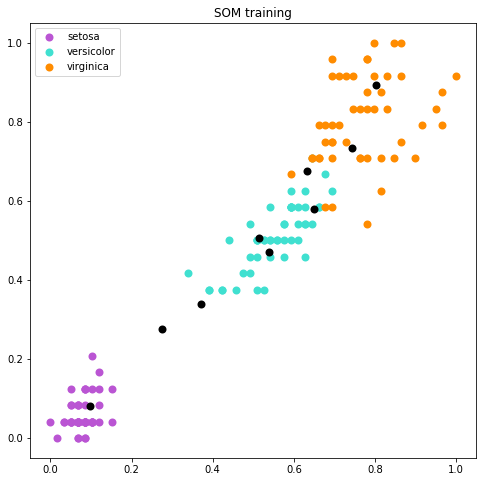

epoch  20


In [35]:
from IPython.display import clear_output
from time import sleep


def plot(xtrain, ytrain, target_names, mapsom, epoch):
  colors = ['mediumorchid', 'turquoise', 'darkorange']
  plt.figure(figsize=(8, 8))
  for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(xtrain[ytrain == i, 0], xtrain[ytrain == i, 1], color=color, lw=2, label=target_name)
  for node in mapsom:
    plt.scatter(node[0], node[1], color='black', lw=2)

  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title('SOM training')
  clear_output(wait=True)
  plt.show()
  print("epoch ", epoch)

target_names = iris.target_names
#target_names = "aleatorio"
for i, mapsom in enumerate(som.map_history):
  plot(x, y, target_names, mapsom, i)


In [36]:
%%time
mapsom1 = SOM(3, 3, x.shape[1], epochs=20, usePCA=False, sigma=1)
mapsom1.fit(x)


mapsom2 = SOM(3, 3, x.shape[1], epochs=20, usePCA=True, sigma=1)
mapsom2.fit(x)

100%|██████████| 20/20 [00:00<00:00, 69.25it/s]

CPU times: user 530 ms, sys: 29.4 ms, total: 559 ms
Wall time: 553 ms


# Comparação

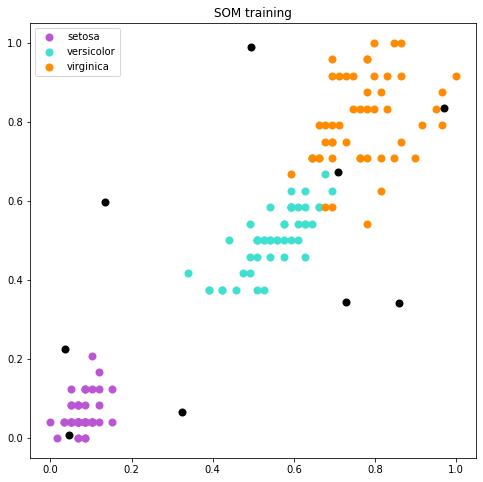

In [37]:
colors = ['mediumorchid', 'turquoise', 'darkorange']
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
  plt.scatter(x[y == i, 0], x[y == i, 1], color=color, lw=2, label=target_name)
for node in mapsom1.map_history[0]:
  plt.scatter(node[0], node[1], color='black', lw=2)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('SOM training')
plt.show()

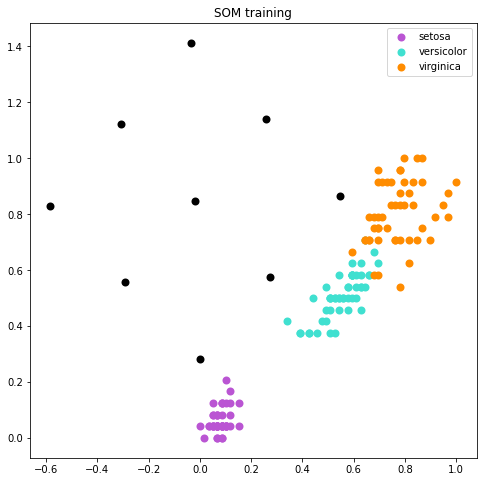

In [33]:
colors = ['mediumorchid', 'turquoise', 'darkorange']
plt.figure(figsize=(8, 8))
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
  plt.scatter(x[y == i, 0], x[y == i, 1], color=color, lw=2, label=target_name)
for node in mapsom2.map_history[0]:
  plt.scatter(node[0], node[1], color='black', lw=2)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('SOM training')
plt.show()